In [15]:
'''
Zé Fonseca

08/03/17

Select a sample of SNeIa and run MCMC using a uniform prior in the numerical marginalization.
'''

import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
#from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
import sys

%matplotlib inline

## Data info

* N_SNeIa=100, uniform distribution;
* errors: $\sigma_\mu=0.2$, $\sigma_z=0.04(1+z)$;


In [16]:
#cosmological functions
#general functions

def invH(z,OM,w):
    return (OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))**(-.5)

c=2.99792e5

def mu(z,OM,H0,w):
    if type(z)==float or type(z)==int:
        return 5*np.log10((1+z)/H0*c*quad(invH,0,z,args=(OM,w))[0])+25
    else:
        dl=[]
        for i in range(len(z)):
            dl.append(quad(invH,0,z[i],args=(OM,w))[0])
        return 5*np.log10(np.array(dl)*(1+z)*c/H0)+25

#class fake data with all the cases.

class fkd:
    def __init__(self,name,filename,index,OM=0.31,H0=67.74,w=-1,sig_mu=0.2,sig_z_per=0.04):
        #parameters used
        self.OM=OM
        self.H0=H0
        self.w=w
        self.dataset=name
        
        dados=np.loadtxt(filename)
        self.z=dados[index,0]
        self.sig_z_per=sig_z_per
        self.sig_z=sig_z_per*(1+self.z)
        self.mu_o=dados[index,1]
        self.sig_mu=sig_mu


In [173]:
#choose a sample of 100 SNe, The same for all
N=100
index=np.unique(np.random.randint(1000,size=N))
l_ind=len(index)
while l_ind<N:
    index=np.unique(np.append(index,np.random.randint(1000,size=N-l_ind)))
    l_ind=len(index)

#initiate data
fd1=fkd('fd1','../Datasets_old/data_fd1_case1_zf.txt',index)
fd2=fkd('fd1_case21','../Datasets_old/data_fd1_case21_zf.txt',index)
#fd3=fkd('fd1_case22','../Datasets_old/data_fd1_case22_zf.txt',index)


# Part 2

## MCMC to data with errors in z

Notes: when adding errors in MCMC we need 3 different error adding. Case 3 does not have mu errors increased in quadrature. 

The likelihood to use is
\begin{equation}
\log L_i=-\frac{1}{2}\left(\frac{\mu_{\rm Obs,i}-\mu(z_{\rm Obs,i},\Omega_m,H_0,w)}{\sigma_\mu}\right)^2
\end{equation}
with
\begin{equation}
\log L=\sum_i \log L_i
\end{equation}


In [174]:
# Functions

#MCMC priors
def prior_om(x):
    if x>=0 and x<=1:
        return 1
    else:
        return 0
    
def prior_w(x):
    if x>=-3 and x<=0:
        return 1
    else:
        return 0
    
def prior_H0(x):
    if x>=50 and x<=100:
        return 1
    else:
        return 0
    
def chi2(mu_o,mu_t,sigma2):
    return (mu_o-mu_t)**2/sigma2

def log_like_fixsig(data,om,H0,w):
    mu_t=mu(data.z,om,H0,w)
    return -chi2(data.mu_o,mu_t,data.sig_mu**2)/2


In [175]:
def MCMC_SNe(N,data,loglike_func=log_like_fixsig):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    log_like=np.zeros(N)
    
    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    log_like[0]=sum(loglike_func(data,o_m[0],H0[0],w[0]))
    
    #dummy var for acceptance rate
    accept=1
    for i in range(N-1):
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.03
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1]=log_like[i]
            continue
        else:
            #compute new log_like
            log_like[i+1]=sum(loglike_func(data,o_m[i+1],H0[i+1],w[i+1]))
            #if priors not flat they need to be included after the exp. for now flat prior
            r=np.exp(log_like[i+1]-log_like[i])
            #accept or not
            teste=np.random.rand()
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1]=log_like[i]
                continue
                
        #really cool piece of code from Ethan but breaks for no reason ramdomly???
        accept+=1
        if i%1000==0:
            inc100 = np.int64(i/(N)*100)
            inc50 = np.int64(i/(N)*50)
            sys.stdout.write('\r')
            sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
            sys.stdout.flush()
    
    acceptr=accept/N*100
    return o_m,w,H0,log_like,acceptr

## Make plots

In [176]:
def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

datas={'0':fd1,'1':fd2}#,'2':fd3}
nb=20
cor=['k','b']#,'r']

def plot_contour_hist_1(data1,burn_tail=500,thining=1,nb=10,loglike='normal'):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    
    if loglike=='normal':
        om=data1.nl_o_m[burn_tail::thining]
        w=data1.nl_w[burn_tail::thining]
        H0=data1.nl_H0[burn_tail::thining]
    if loglike=='am_fixhyper':
        om=data1.anlm_o_m[burn_tail::thining]
        w=data1.anlm_w[burn_tail::thining]
        H0=data1.anlm_H0[burn_tail::thining]
    if loglike=='num_marg':
        om=data1.nmarg_o_m[burn_tail::thining]
        w=data1.nmarg_w[burn_tail::thining]
        H0=data1.nmarg_H0[burn_tail::thining]
    if loglike=='am_fithyper':
        om=data1.fithyper_o_m[burn_tail::thining]
        w=data1.fithyper_w[burn_tail::thining]
        H0=data1.fithyper_H0[burn_tail::thining]
    if loglike=='num_marg_fithyper':
        om=data1.nmarg_fithyper_o_m[burn_tail::thining]
        w=data1.nmarg_fithyper_w[burn_tail::thining]
        H0=data1.nmarg_fithyper_H0[burn_tail::thining]    
    
    Hist_mcmc, omedges,wedges = np.histogram2d(om,w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Neff=len(om)
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Neff)
    #plt.plot(om_max,w_max,'rx',ms=10)
    
    bins_om=[round(x*0.025,3) for x in range(0,40)]
    bins_w=[round(x*0.05-6,3) for x in range(0,140)]
    bins_H=[x*0.25+50 for x in range(0,500)]

        
    om_min=np.amin(om)
    om_max=np.amax(om)
    
    w_min=np.amin(w)
    w_max=np.amax(w)
    
    H0_min=np.amin(H0)
    H0_max=np.amax(H0)
               
    axarr[0,0].hist(om,color='r',bins=bins_om,alpha=0.15)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    axarr[1,0].contour(om_c,w_c, Hist_mcmc.T,levels=[N95,N68,Nmax])
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    
    axarr[0,1].hist(H0,bins=bins_H,color='r',alpha=0.15)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    
    axarr[1,1].hist(w,bins=bins_w,color='r',alpha=0.15,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    axarr[1,1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.show()
    
def plot_conv_mcmc(data1,burn_tail=0,thining=1,loglike='normal'):
    
    f, axarr = plt.subplots(3,1,figsize=(8,12))
    
    if loglike=='normal':
        om=data1.nl_o_m[burn_tail::thining]
        w=data1.nl_w[burn_tail::thining]
        H0=data1.nl_H0[burn_tail::thining]
    if loglike=='am_fixhyper':
        om=data1.anlm_o_m[burn_tail::thining]
        w=data1.anlm_w[burn_tail::thining]
        H0=data1.anlm_H0[burn_tail::thining]
    if loglike=='num_marg':
        om=data1.nmarg_o_m[burn_tail::thining]
        w=data1.nmarg_w[burn_tail::thining]
        H0=data1.nmarg_H0[burn_tail::thining]
    if loglike=='am_fithyper':
        om=data1.fithyper_o_m[burn_tail::thining]
        w=data1.fithyper_w[burn_tail::thining]
        H0=data1.fithyper_H0[burn_tail::thining]
    if loglike=='num_marg_fithyper':
        om=data1.nmarg_fithyper_o_m[burn_tail::thining]
        w=data1.nmarg_fithyper_w[burn_tail::thining]
        H0=data1.nmarg_fithyper_H0[burn_tail::thining]   
        
    axarr[0].plot(om)
    axarr[0].set_ylim([np.amin(om),np.amax(om)])
    axarr[0].set_ylabel(r'$\Omega_M$')
    
    axarr[1].plot(w)
    axarr[1].set_ylim([np.amin(w),np.amax(w)])
    axarr[1].set_ylabel(r'$w$')
    
    axarr[2].plot(H0)
    axarr[2].set_ylim([np.amin(H0),np.amax(H0)])
    axarr[2].set_ylabel(r'$H_0$')
    
    plt.setp(axarr[0].get_xticklabels(), visible=False)
    plt.setp(axarr[1].get_xticklabels(), visible=False)
    
    plt.show()

# Run for dataset with normal likelihood

In [177]:
Nsteps=100000

In [178]:
fd1.nl_o_m,fd1.nl_w,fd1.nl_H0,fd1.nl_log_like,fd1.nl_acceptr=MCMC_SNe(Nsteps,fd1,log_like_fixsig)
print('\n',fd1.nl_acceptr)


[################################################# ]98%
 36.576


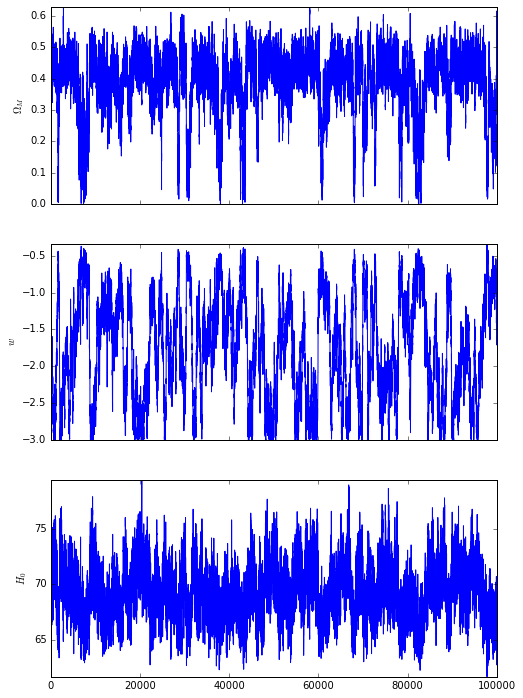

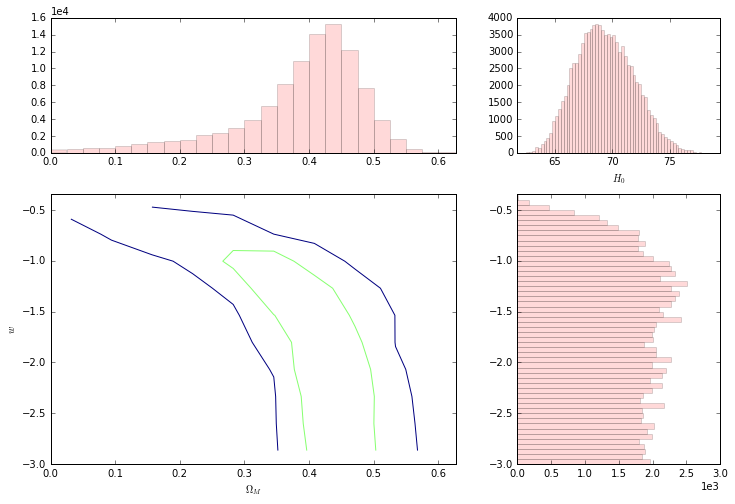

In [179]:
plot_conv_mcmc(fd1)
plot_contour_hist_1(fd1)


[################################################# ]99%
 37.669999999999995


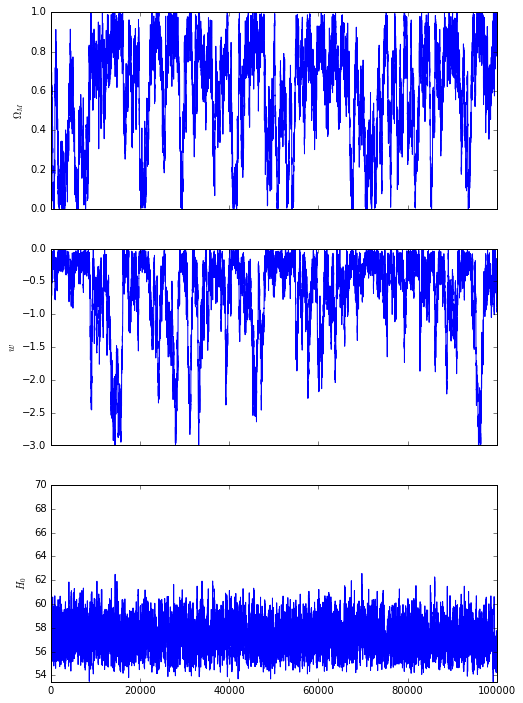

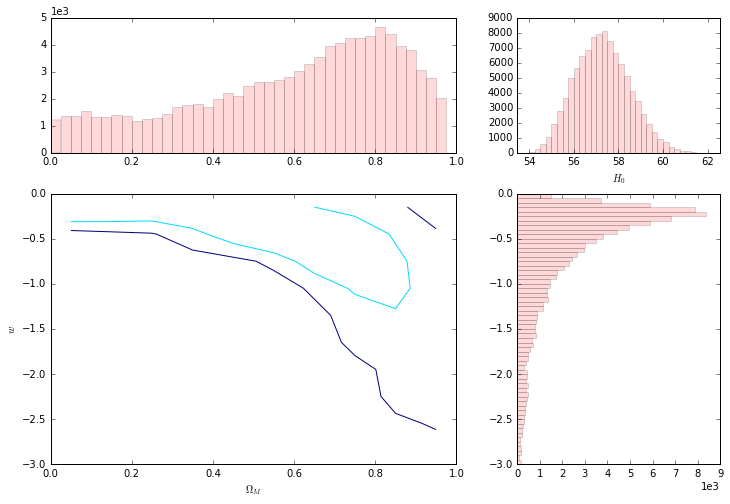

In [180]:
fd2.nl_o_m,fd2.nl_w,fd2.nl_H0,fd2.nl_log_like,fd2.nl_acceptr=MCMC_SNe(Nsteps,fd2,log_like_fixsig)
print('\n',fd2.nl_acceptr)
plot_conv_mcmc(fd2)
plot_contour_hist_1(fd2)
plt.show()

In [88]:
#fd3.nl_o_m,fd3.nl_w,fd3.nl_H0,fd3.nl_log_like,fd3.nl_acceptr=MCMC_SNe(Nsteps,fd3,log_like_fixsig)
#print('\n',fd3.nl_acceptr)
#plot_conv_mcmc(fd3)
#plot_contour_hist_1(fd3)
#plt.show()

In [89]:
fd2.nl_o_m

array([ 0.3       ,  0.27071865,  0.27071865, ...,  0.20077755,
        0.23092693,  0.25330261])

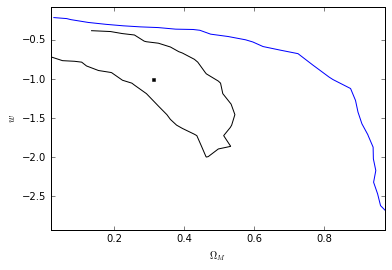

In [168]:
datas={'0':fd1,'1':fd2}#,'2':fd3}
nb=20
cor=['k','b']#,'r']
for i in range(2):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].nl_o_m,datas[str(i)].nl_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
#plt.xlim([0,0.8])
#plt.ylim([-2,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

#plt.savefig('../general_datasets/5cosmo_chains.png')
plt.show()

## Numerical marginalization, no hyperparameters 

Use the likelihood:
\begin{equation}
\log L_i=-\frac{1}{2} \left(\frac{(z_{\rm Obs,i}-z_i)^2}{\sigma_z^2}+\frac{(\mu_{\rm Obs,i}-\mu(z_i,\Omega_m,H_0,w))^2}{\sigma_{\mu}^2} \right) + constants
\end{equation}

And we fit for $\vartheta=\Omega_m,H_0,w,z_i$. We will do the fit stepwise. First for the cosmological parameters and then for each z individually. 


In [145]:
def log_like_nummarg(data,om,H0,w,zs):
    mu_t=mu(zs,om,H0,w)
    return -0.5*(((data.z-zs)/(data.sig_z))**2+((data.mu_o-mu_t)/data.sig_mu)**2)

def prior_z(x):
    if x>=0 and x<=1:
        return 1
    else:
        return 0

def MCMC_SNe_nmarg(N,data):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)    
    nzs=len(data.z)
    zs=np.zeros((N,nzs))
    log_like=np.zeros((N,2))
    
    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    zs[0,:]=data.z
    log_like[0,0]=sum(log_like_nummarg(data,o_m[0],H0[0],w[0],zs[0,:]))
    log_like[0,-1]=sum(log_like_nummarg(data,o_m[0],H0[0],w[0],zs[0,:]))
    #
    accecpt=101
    for i in range(N-1):
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.03
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        zs[i+1,:]=zs[i,:]+np.random.randn(nzs)*0.005
        accecpt+=101
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1,0]=log_like[i,-1]
            accecpt-=1
        else:
            log_like[i+1,0]=sum(log_like_nummarg(data,o_m[i+1],H0[i+1],w[i+1],zs[i,:]))
            r=np.exp(log_like[i+1,0]-log_like[i,-1])
            teste=np.random.rand()
            
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1,0]=log_like[i,-1]
                accecpt-=1
        
        
        for j in range(nzs):
            if prior_z(zs[i+1,j])==0:
                zs[i+1,j]=zs[i,j]
                accecpt-=1
        
        log_like_old=log_like_nummarg(data,o_m[i+1],H0[i+1],w[i+1],zs[i,:])
        log_like_new=log_like_nummarg(data,o_m[i+1],H0[i+1],w[i+1],zs[i+1,:])
        r=np.exp(log_like_new-log_like_old)
        teste=np.random.rand(nzs)
        for j in range(nzs):
            if r[j]<teste[j]:
                zs[i+1,j]=zs[i,j]
                accecpt-=1
        
        log_like[i+1,-1]=sum(log_like_nummarg(data,o_m[i+1],H0[i+1],w[i+1],zs[i+1,:]))
        
        if i%1000==0:
            inc100 = np.int64(i/(N)*100)
            inc50 = np.int64(i/(N)*50)
            sys.stdout.write('\r')
            sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
            sys.stdout.flush()
            
    acpt_ratio=accecpt/(N*101)
    
    data.nmarg_o_m=o_m
    data.nmarg_w=w
    data.nmarg_H0=H0
    data.nmarg_zs=zs
    data.nmarg_log_like=log_like
    data.nmarg_acpt_ratio=acpt_ratio
    

In [181]:
MCMC_SNe_nmarg(Nsteps,fd1)

[################################################# ]99%

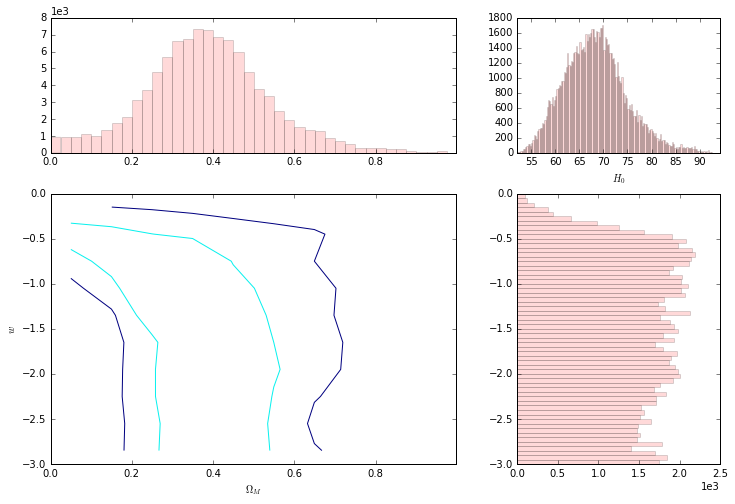

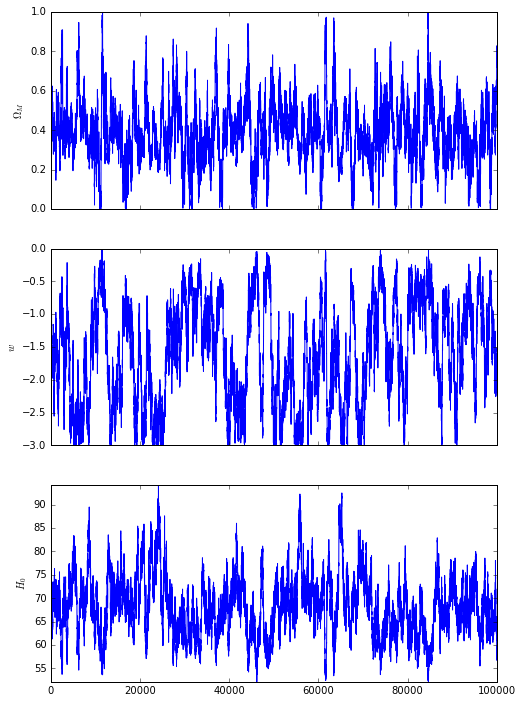

In [182]:
plot_contour_hist_1(fd1,loglike='num_marg')
plot_conv_mcmc(fd1,loglike='num_marg')



0.547


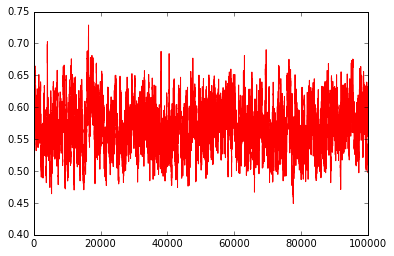

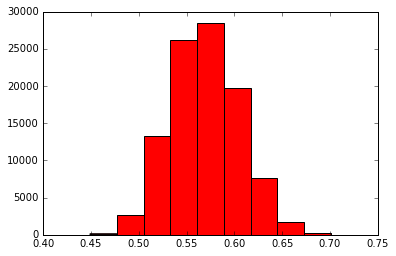

In [183]:
print(fd1.z[50])
plt.plot(fd1.nmarg_zs[:,50],color='r')
plt.show()
plt.hist(fd1.nmarg_zs[:,50],color='r')
plt.show()



In [184]:
#Nsteps
MCMC_SNe_nmarg(Nsteps,fd2)
#MCMC_SNe_nmarg(Nsteps,fd3)

[################################################# ]99%

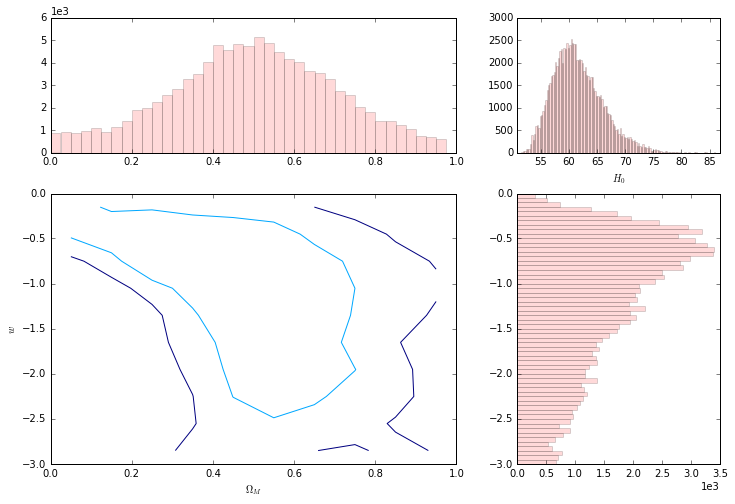

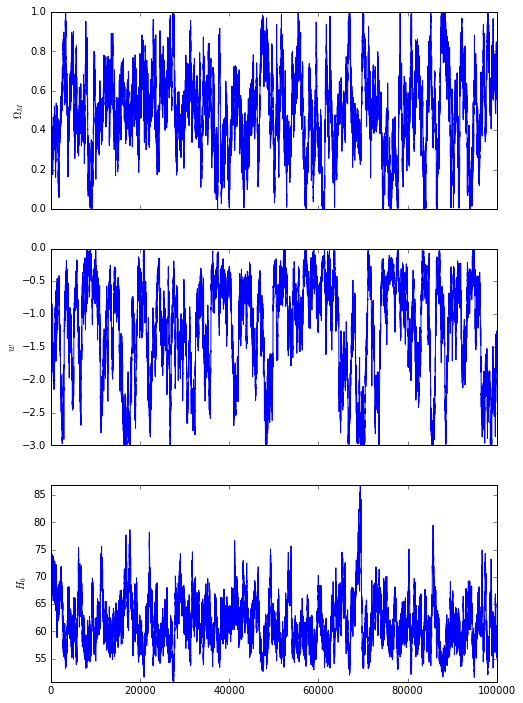

In [185]:
plot_contour_hist_1(fd2,loglike='num_marg')
plot_conv_mcmc(fd2,loglike='num_marg')


#plot_contour_hist_1(fd3,loglike='num_marg')

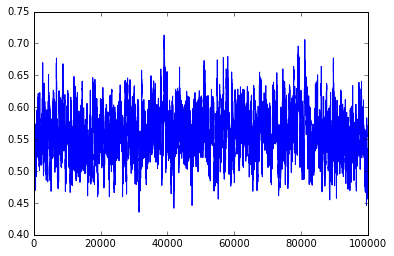

In [186]:
plt.plot(fd2.nmarg_zs[:,50],color='b')
#plt.plot(fd3.nmarg_zs[:,50],color='g')
plt.show()

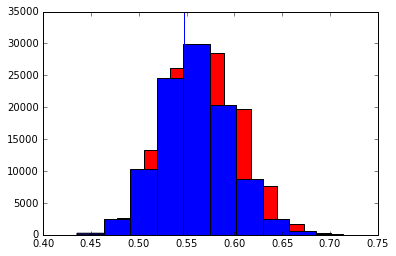

In [187]:
plt.hist(fd1.nmarg_zs[:,50],color='r')
plt.hist(fd2.nmarg_zs[:,50],color='b')
#plt.hist(fd3.nmarg_zs[:,50],color='g')
plt.plot([fd1.z[50],fd1.z[50]],[0,35000])

In [188]:
print(fd1.z[50])
print(fd2.z[50])


0.547
0.521


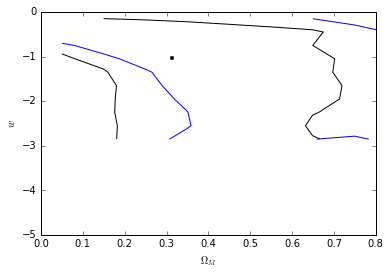

In [189]:
#datas={'0':fd1,'1':fd2,'2':fd3}
nb=10
cor=['k','b']#,'r','g','m']
for i in range(2):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].nmarg_o_m,datas[str(i)].nmarg_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

#plt.savefig('../general_datasets/5cosmo_chains_nummarg_fixhyper.png')
plt.show()

## Make errors bigger



In [101]:
fd3=fkd('fd1_case21','../Datasets_old/data_fd1_case21_zf.txt',index,sig_z_per=0.08)

In [102]:
fd3.nl_o_m,fd3.nl_w,fd3.nl_H0,fd3.nl_log_like,fd3.nl_acceptr=MCMC_SNe(Nsteps,fd3,log_like_fixsig)
MCMC_SNe_nmarg(Nsteps,fd3)


[################################################# ]99%

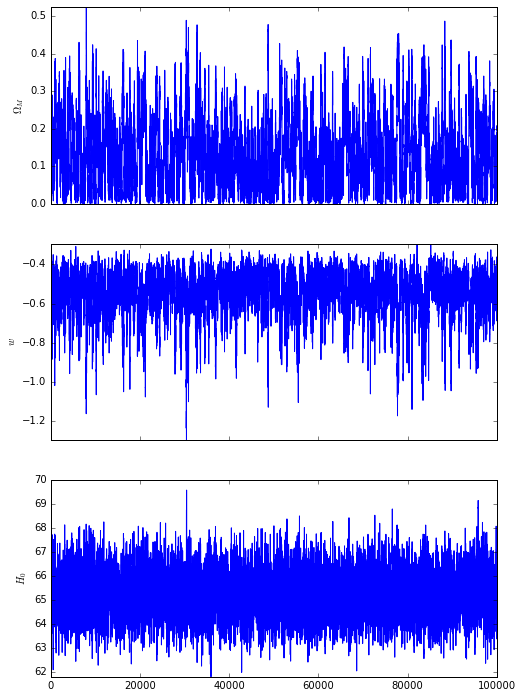

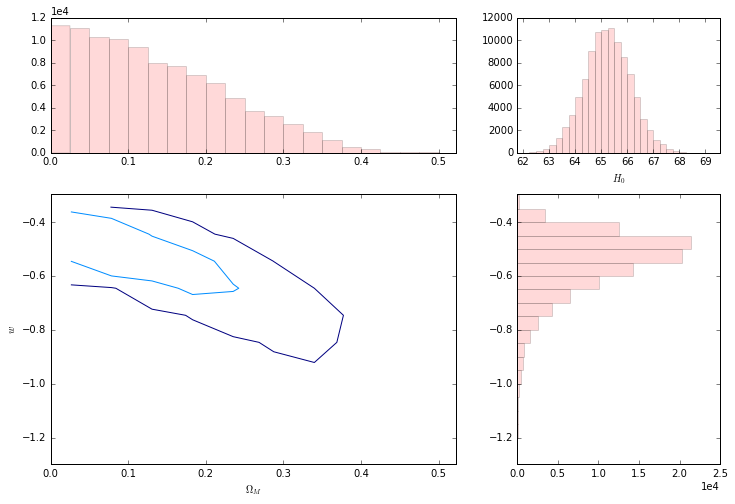

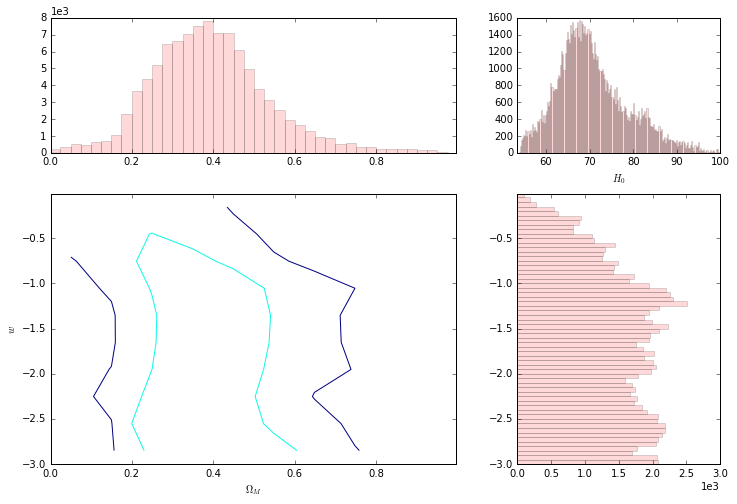

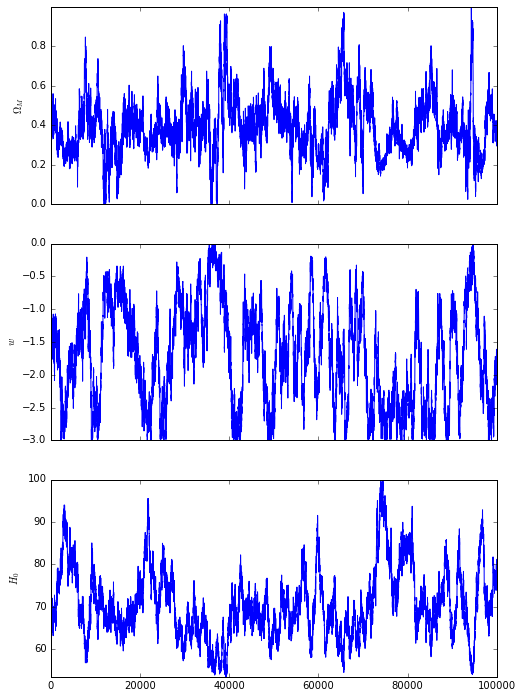

In [103]:
plot_conv_mcmc(fd3)
plot_contour_hist_1(fd3)
plot_contour_hist_1(fd3,loglike='num_marg')
plot_conv_mcmc(fd3,loglike='num_marg')



In [190]:
## Reduce even further the priors
def prior_w(x):
    if x>=-2 and x<=0:
        return 1
    else:
        return 0
    
def prior_H0(x):
    if x>=60 and x<=90:
        return 1
    else:
        return 0

In [191]:
fd4=fkd('fd1_case21','../Datasets_old/data_fd1_case21_zf.txt',index)

In [192]:
fd4.nl_o_m,fd4.nl_w,fd4.nl_H0,fd4.nl_log_like,fd4.nl_acceptr=MCMC_SNe(Nsteps,fd4,log_like_fixsig)
MCMC_SNe_nmarg(Nsteps,fd4)

[################################################# ]99%

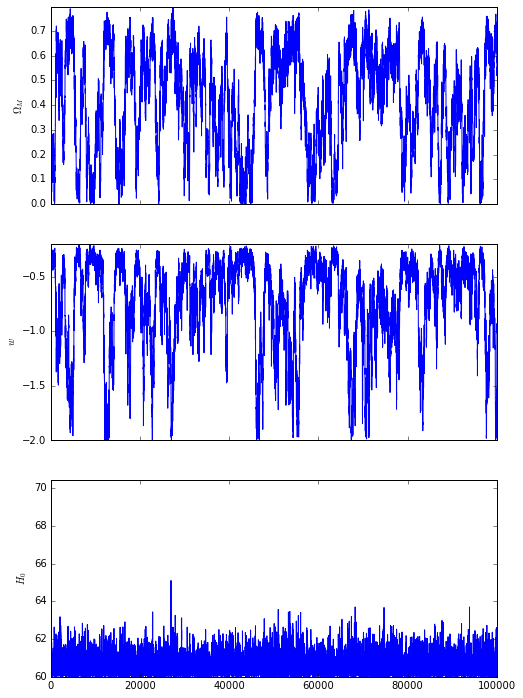

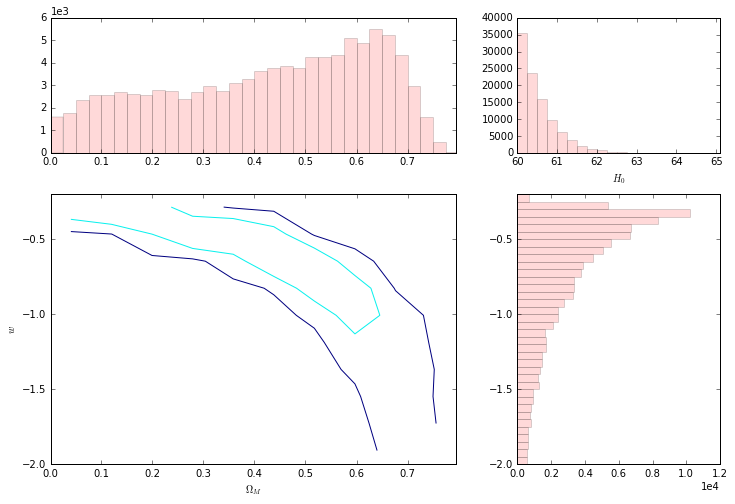

In [193]:
plot_conv_mcmc(fd4)
plot_contour_hist_1(fd4)

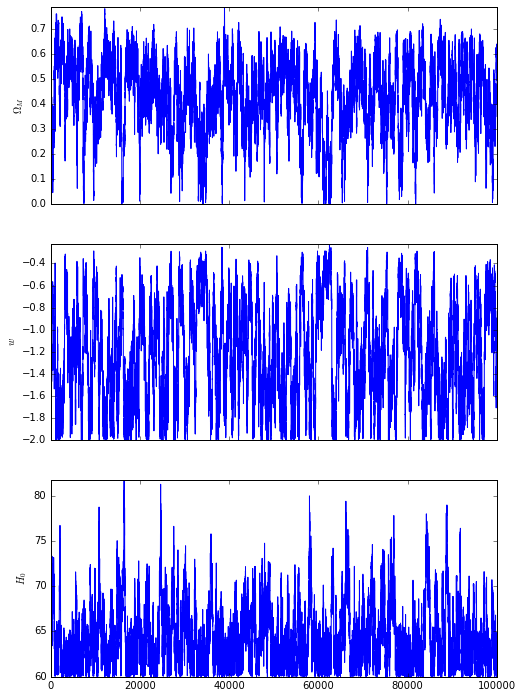

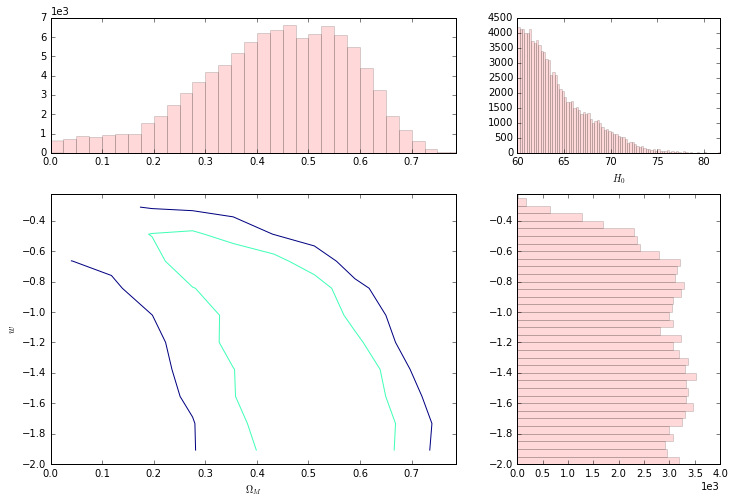

In [194]:
plot_conv_mcmc(fd4,loglike='num_marg')
plot_contour_hist_1(fd4,loglike='num_marg')

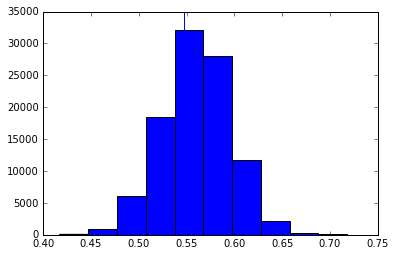

In [195]:
#plt.hist(fd3.nmarg_zs[:,50],color='r')
plt.hist(fd4.nmarg_zs[:,50],color='b')

plt.plot([fd1.z[50],fd1.z[50]],[0,35000])

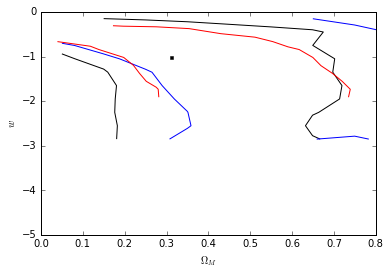

In [196]:
datas2={'0':fd1,'1':fd2,'2':fd4}
nb=10
cor=['k','b','r','g','m']
for i in range(3):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas2[str(i)].nmarg_o_m,datas2[str(i)].nmarg_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

#plt.savefig('../general_datasets/5cosmo_chains_nummarg_fixhyper.png')
plt.show()

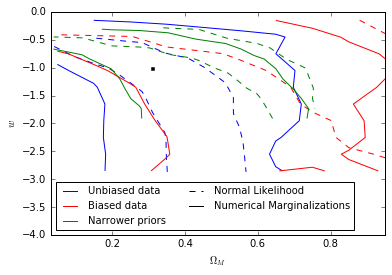

In [197]:
datas2={'0':fd1,'1':fd2,'2':fd4}
nb=10
cor=['b','r','g','m']
for i in range(3):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas2[str(i)].nmarg_o_m,datas2[str(i)].nmarg_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
    Hist_mcmc, omedges,wedges = np.histogram2d(datas2[str(i)].nl_o_m,datas2[str(i)].nl_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    plt.contour(om_c,w_c, -Hist_mcmc.T,levels=[-Nmax,-N95],colors=cor[i],ls='dashed')
    #plt.set_linestyle('dashed')


plt.plot(0.31,-1,'sk',ms=3)
import matplotlib.lines as mlines

black_line = mlines.Line2D([], [], color='k', label='Numerical Marginalizations')
black_dashed_line = mlines.Line2D([], [], color='k',ls='--', label='Normal Likelihood')
blue_line = mlines.Line2D([], [], color='b',ls='-', label='Unbiased data')
red_line = mlines.Line2D([], [], color='r',ls='-', label='Biased data')
green_line = mlines.Line2D([], [], color='g',ls='-', label='Narrower priors')


plt.legend(handles=[blue_line,red_line,green_line,black_dashed_line,black_line],loc=3,fontsize=10,ncol=2)
    
#plt.xlim([0,0.8])
plt.ylim([-4,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/nummarg_nSNe100.png')
plt.show()

## Check likelihood

In [ ]:
w=np.arange(-2,0,0.01)
loglike_w=np.zeros(len(w))
loglike_w1=np.zeros(len(w))
loglike_w2=np.zeros(len(w))
randvec=np.zeros(100)
randvec[np.random.randint(100)]=0.001
for i in range(len(w)):
    loglike_w[i]=sum(log_like_fixsig(fd1,0.31,67.74,w[i]))
    loglike_w1[i]=sum(log_like_nummarg(fd2,0.31,67.74,w[i],fd2.z))
    loglike_w2[i]=sum(log_like_nummarg(fd2,0.31,67.74,w[i],fd2.z+randvec))

plt.plot(w,loglike_w,'k')
plt.plot(w,loglike_w1,'b')
plt.plot(w,loglike_w2,'r')
plt.show()

In [ ]:
np.random.randint(100)

In [ ]:
w=np.arange(-2,0,0.01)
loglike_w=np.zeros(len(w))
for i in range(len(w)):
    loglike_w[i]=sum(log_like_fixsig(fd1,0.31,67.74,w[i]))

plt.plot(w,loglike_w)
plt.show()


## Numerical marginalization, fit hyperparameters 

Use the likelihood:
\begin{equation}
\log L_i=-\frac{1}{2} \left(\frac{(z_{\rm Obs,i}-z_i)^2}{\sigma_z^2}+\frac{(\mu_{\rm Obs,i}-\mu(z_i,\Omega_m,H_0,w))^2}{\sigma_{\mu}^2} + \frac{(z_i-\bar z)^2}{\sigma_p^2} \right) + constants
\end{equation}

And we fit for $\vartheta=\Omega_m,H_0,w,z_i,\bar z, \sigma_p$. We will do the fit stepwise. First for the cosmological parameters, then for each z individually and then hyper parameters. 



In [ ]:
def log_like_nummarg_fithyper(data,om,H0,w,zs,zb,sp):
    mu_t=mu(zs,om,H0,w)
    return -0.5*(((data.z-zs)/(data.sig_z))**2+((data.mu_o-mu_t)/data.sig_mu)**2+\
                 ((zs-zb)/sp)**2)

def MCMC_SNe_nmarg_fithyper(N,data):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)    
    nzs=len(data.z)
    zs=np.zeros((N,nzs))
    log_like=np.zeros((N,2))
    zb=np.zeros(N)
    sp=np.zeros(N)
    
    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    zs[0,:]=data.z+np.random.randn(nzs)*0.05
    zb[0]=0.4
    sp[0]=0.2
    log_like[0,:]=sum(log_like_nummarg_fithyper(data,o_m[0],H0[0],w[0],zs[0,:],zb[0],sp[0]))
    
    for i in range(N-1):
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        zs[i+1,:]=zs[i,:]+np.random.randn(nzs)*0.01
        zb[i+1]=zb[i]+np.random.randn()*0.01
        sp[i+1]=sp[i]+np.random.randn()*0.01
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1,0]=log_like[i,-1]
        else:
            log_like[i+1,0]=sum(log_like_nummarg_fithyper(data,o_m[i+1],H0[i+1],w[i+1],zs[i,:],zb[i],sp[i]))
            r=np.exp(log_like[i+1,0]-log_like[i,-1])
            teste=np.random.rand()
            
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1,0]=log_like[i,-1]
         
        log_like_old=log_like_nummarg_fithyper(data,o_m[i+1],H0[i+1],w[i+1],zs[i,:],zb[i],sp[i])
        log_like_new=log_like_nummarg_fithyper(data,o_m[i+1],H0[i+1],w[i+1],zs[i+1,:],zb[i],sp[i])
        r=np.exp(log_like_new-log_like_old)
        teste=np.random.rand(nzs)
        for j in range(nzs):
            if r[j]<teste[j]:
                zs[i+1,j]=zs[i,j]
                log_like_new[j]=log_like_old[j]
    
        
        if prior_zb(zb[i+1])==0 or prior_sp(sp[i+1])==0:
            zb[i+1]=zb[i]
            sp[i+1]=sp[i]
            log_like[i+1,-1]=sum(log_like_new)
            continue
        else:
            #compute new log_like
            log_like[i+1,-1]=sum(log_like_nummarg_fithyper(data,o_m[i+1],H0[i+1],w[i+1],zs[i+1,:],zb[i+1],sp[i+1]))
            log_like_old_zbsp=sum(log_like_new)
            #if priors not flat they need to be included after the exp. for now flat prior
            r=np.exp(log_like[i+1,-1]-log_like_old_zbsp)
            #accept or not
            teste=np.random.rand()
            #if r lower than teste then don't accept
            if r<teste:
                zb[i+1]=zb[i]
                sp[i+1]=sp[i]
                log_like[i+1,-1]=log_like_old_zbsp
        
        if i%1000==0:
            inc100 = np.int64(i/(N)*100)
            inc50 = np.int64(i/(N)*50)
            sys.stdout.write('\r')
            sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
            sys.stdout.flush()
    
    data.nmarg_fithyper_o_m=o_m
    data.nmarg_fithyper_w=w
    data.nmarg_fithyper_H0=H0
    data.nmarg_fithyper_zs=zs
    data.nmarg_fithyper_zb=zb
    data.nmarg_fithyper_sp=sp
    data.nmarg_fithyper_log_like=log_like
    

In [ ]:
MCMC_SNe_nmarg_fithyper(500000,fd1)

In [ ]:
plot_contour_hist_1(fd1,nb=20,loglike='num_marg_fithyper')

In [ ]:
MCMC_SNe_nmarg_fithyper(500000,fd2)
MCMC_SNe_nmarg_fithyper(500000,fd3)
MCMC_SNe_nmarg_fithyper(500000,fd4)
MCMC_SNe_nmarg_fithyper(500000,fd5)

In [ ]:
plot_contour_hist_1(fd2,nb=20,loglike='num_marg_fithyper')
plot_contour_hist_1(fd3,nb=20,loglike='num_marg_fithyper')
plot_contour_hist_1(fd4,nb=20,loglike='num_marg_fithyper')
plot_contour_hist_1(fd5,nb=20,loglike='num_marg_fithyper')

In [ ]:
datas={'0':fd1,'1':fd2,'2':fd3,'3':fd4,'4':fd5}
nb=20
cor=['k','b','r','g','m']
for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].nmarg_fithyper_o_m,datas[str(i)].nmarg_fithyper_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/5cosmo_chains_nummarg_fithyper.png')
plt.show()